# <center> Newman on custom trace and user graph </center>

In [2]:
import sys
import util
import numpy as np
import networkx as nx
import random as random
from time import time
from operator import itemgetter
import matplotlib.pyplot as plt
from math import log
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

Trace and real graph path.

In [3]:
trace_path = "../Newman/rapportStage/trace_normal.txt"
graph_path = "../Newman/rapportStage/adjList_normal.txt"

Out path.

In [15]:
out_path = "../Newman/rapportStage/results_normal/"

Get authors.

In [4]:
Author = util.get_authors(trace_path)

Get users.

In [5]:
users = set(Author.values())
# print(users)

Show beginning of trace.

In [6]:
for i,line in enumerate(open(trace_path)):
    print(line[:-1]) # [:-1] to remove \n at end of line
    if i==5:
        break

1 0.0002320407491522085 51 -1
2 0.0006118585945935823 42 -1
3 0.0007774102808583195 36 -1
4 0.0007851068335115537 50 -1
5 0.0011044432224044177 36 -1
6 0.0013630647560282801 53 -1


Useful function to flatten a list of lists or values from dict of dicts.

In [7]:
def flatten(obj):
    if type(obj) == list:
        return [l for L in obj for l in L]
    if type(obj) == dict:
        return [l for i in obj for l in obj[i].values()]

# example
liste = [[3,5], [0,-7,12], [45]]
print("Example on {} : {}".format(liste, flatten(liste)))
dico = {1: {4:56, 2:45}, 3: {6:32}}
print("Example on {} : {}".format(dico, flatten(dico)))

Example on [[3, 5], [0, -7, 12], [45]] : [3, 5, 0, -7, 12, 45]
Example on {1: {4: 56, 2: 45}, 3: {6: 32}} : [56, 45, 32]


## 1. Initialization

Number of nodes $n$ and list of all node pairs.

In [8]:
n = len(users)
node_pairs = list()
for i in range(n):
    for j in range(n):
        if i != j:
            node_pairs.append((i,j))

Compute E and N. Here N for edge $i \rightarrow j$ equals the total number of retweets by $j$. To set all N to the maximal number of retweets among all users do `N=max(flatten(E))`.

Note that if E is too big it can cause divisions by zeros in the algorithm. Usually E<200 is fine. You can force E<some chosen value.

In [9]:
# init
N = dict()
E = dict()

# read tweets
for i,line in enumerate(open(trace_path)):
    line = line.split()
    uid, rtid = int(line[2]), int(line[3])
    
    # if retweet of known author
    if rtid != -1:
        if uid not in N:
            N[uid] = 1
        else:
            N[uid] += 1
        if rtid in Author:
            rtu = Author[rtid]
            if rtu != uid: # no self-edges
                if uid in E:
                    if rtu in E[uid]:# and E[uid][rtu] < 100:
                        E[uid][rtu] += 1
                    else:
                        E[uid][rtu] = 1
                else:
                    E[uid] = {rtu: 1}

print("N = ", set(N.values()))

N =  {20, 27, 28, 29, 30, 31, 32, 34, 35, 36, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 70, 71, 73, 80}


In [10]:
print(max(flatten(E)))
N = {u:max(flatten(E)) for u in N}

22


## 2. Iterations

Choose parameters.

In [11]:
eps = 10**(-3) # convergence criterion
repetitions = 100 # number of times we repeat the algorithm
max_iter = 100 # max number of iterations
verbose = False # True to print some infos at each iteration

Proceed NEW VERSION SPARSE.

In [12]:
# at each repetition we save the values of w, a and b
results = {'w':list(), 'a':list(), 'b':list()}

start = time()
for k in range(repetitions):
    
    # we may have divisions by zero
    try:
    
        # random initialization of the parameters
        w = random.uniform(0, 0.2)
        a = random.uniform(0.5, 1)
        b = random.uniform(0, 0.5)
#         w = random.random()
#         a = random.random()
#         b = random.random()
        if verbose:
            print("init values ", w, a, b)
            print()

        # iter
        for l in range(max_iter):
            
            # print state
            sys.stdout.flush()
#             sys.stdout.write("repetition {}/{} --- iteration {}/{} --- elapsed time {:.3f}\r"
#                              .format(k+1, repetitions, l+1, max_iter, time()-start))
            sys.stdout.write("repetition {}/{} --- elapsed time {:.3f}\r"
                             .format(k+1, repetitions, time()-start))

            old_w, old_a, old_b = w, a, b

            # compute Qij
            Q = dict()
            for i in E:
                ni = N[i]
                Q[i] = dict()
                for j in E[i]:
                    eij = E[i][j]
                    qij = w * a**eij * (1-a)**(ni-eij)
                    qij /= w * a**eij * (1-a)**(ni-eij) + (1-w) * b**eij * (1-b)**(ni-eij)
                    Q[i][j] = qij
            
            # update w,a,b
            w = sum(flatten(Q)) / (n*(n-1))
            numerator_a, numerator_b = 0, 0
            denominator_a, denominator_b = 0, 0
            for i in E:
                ni = N[i]
                for j in E[i]:
                    eij = E[i][j]
                    qij = Q[i][j]
                    numerator_a += qij * eij
                    numerator_b += (1-qij) * eij
                    denominator_a += qij * ni
                    denominator_b += (1-qij) * ni
            a = numerator_a / denominator_a
            b = numerator_b / denominator_b
            if verbose:
                print(w,a,b)
                print()
            
            # break if no sufficient evolution after at least one iteration
            # INCOMPLETE
            new_q = np.array(flatten(Q))
            if l>0 and np.linalg.norm(new_q - old_q) < eps:
                if verbose:
                    print(np.abs([a-old_a, b-old_b, w-old_w]))
                break
            
            # register old_q
            old_q = new_q
            
        # add results to results dict
        results['w'].append(w)
        results['a'].append(a)
        results['b'].append(b)
        print("w, a, b = {}, {}, {}".format(w,a,b))
        
    except Exception as e:
        print(e)
        continue

w, a, b = 0.011695712082201333, 0.5056546673204863, 0.09107887950880067
w, a, b = 0.011695527680987338, 0.5056573884181905, 0.09107913307904059
w, a, b = 0.011695701569944155, 0.5056548224429609, 0.09107889396411324
w, a, b = 0.011695657766263778, 0.5056554688258572, 0.09107895419829311
w, a, b = 0.011696687679203623, 0.5056402713793496, 0.09107753802703415
w, a, b = 0.011695767559970675, 0.5056538486726253, 0.09107880322201403
w, a, b = 0.011695864294163331, 0.5056524212363483, 0.0910786702048465
w, a, b = 0.01169587470965125, 0.5056522675428897, 0.09107865588278977
w, a, b = 0.011695719107963774, 0.5056545636459667, 0.0910788698477413
w, a, b = 0.011695788619273262, 0.5056535379152765, 0.09107877426371964
w, a, b = 0.011695725585328578, 0.5056544680638146, 0.09107886094078721
w, a, b = 0.011696703695942886, 0.5056400350408262, 0.09107751600430379
w, a, b = 0.011695729550672674, 0.5056544095498646, 0.09107885548808684
w, a, b = 0.01169562591840133, 0.5056559387851347, 0.09107899799223

Print results and show aggregated best results (rounded to $10^{-5}$).

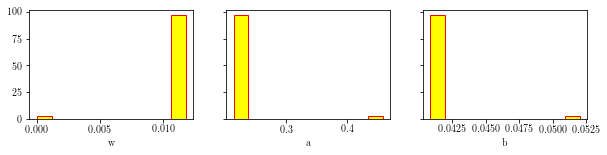

top 5 values for w and proportion
0.0118 0.97
0.0 0.03

top 5 values for a and proportion
0.21451 0.94
0.2145 0.03
0.45821 0.01
0.45819 0.01
0.45822 0.01

top 5 values for b and proportion
0.04089 0.97
0.05202 0.03

top 5 values for (w,a,b) and proportion
(0.0118, 0.21451, 0.04089) 0.94
(0.0118, 0.2145, 0.04089) 0.03
(0.0, 0.45819, 0.05202) 0.01
(0.0, 0.45821, 0.05202) 0.01
(0.0, 0.45822, 0.05202) 0.01



In [15]:
# plot the results
plt.rcParams["figure.figsize"] = [10,2]
fig, ax = plt.subplots(1, 3, sharey=True)
for i,(key,values) in enumerate(results.items()):
    values = sorted(values)
    ax[i].hist(values, label=key, facecolor='yellow', edgecolor='red')
    ax[i].set_xlabel(key)  
plt.show()
plt.close()

# print results
for key,val in results.items():
    print("top 5 values for {} and proportion".format(key))
    val = [round(v,5) for v in val]
    valcount = list()
    for v in set(val):
        valcount.append((v, val.count(v)/len(val)))
    valcount = sorted(valcount, key=itemgetter(1), reverse=True)
    for x in valcount[:5]:
        print(x[0], x[1])
    print()
    
print("top 5 values for (w,a,b) and proportion")
val = list()
for i in range(len(results['w'])):
    val.append((round(results['w'][i],5), round(results['a'][i],5), round(results['b'][i],5)))
valcount = list()
for v in set(val):
    valcount.append((v, val.count(v)/len(val)))
valcount = sorted(valcount, key=itemgetter(1), reverse=True)
for x in valcount[:5]:
    print(x[0], x[1])
print()

Set w,a,b to some chosen values among the results and compute Q accordingly. Plot Q distribution.

w, a, b =  0.011695729550672674 0.5056544095498646 0.09107885548808684


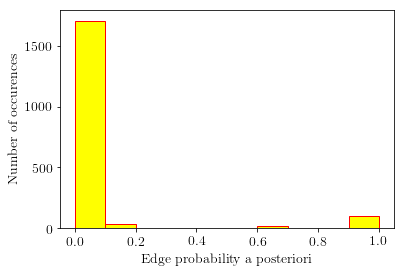

In [13]:
w, a, b = 0.011695729550672674, 0.5056544095498646, 0.09107885548808684

# compute Q
Q = dict()
for i in E:
    ni = N[i]
    Q[i] = dict()
    for j in E[i]:
        eij = E[i][j]
        qij = w * a**eij * (1-a)**(ni-eij)
        qij /= w * a**eij * (1-a)**(ni-eij) + (1-w) * b**eij * (1-b)**(ni-eij)
        Q[i][j] = qij
        
# plot
print("w, a, b = ", w,a,b)
plt.rcParams["figure.figsize"] = [6,4]
plt.hist(flatten(Q), facecolor='yellow', edgecolor='red')
plt.xlabel("Edge probability a posteriori")
plt.ylabel("Number of occurences")
# plt.savefig(out_path + "Q_distrib.pdf")
plt.show()
plt.close()

## 3. Result analysis

### 3.1 Plots

Plot E/N vs Q.

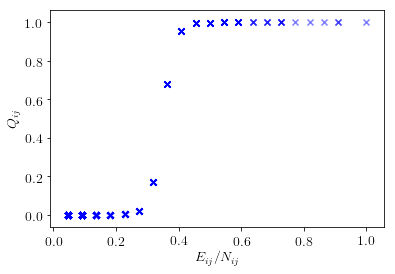

In [17]:
plt.rcParams["figure.figsize"] = [6,4]
x2plot, y2plot = list(), list()
for i in E:
    for j in E[i]:
        x2plot.append(E[i][j] / N[i])
#         x2plot.append(E[i][j])
        y2plot.append(Q[i][j])
# x2plot = flatten(E)
# y2plot = flatten(Q)
fig, ax = plt.subplots()
# ax.set_xscale('log') # log scale
# ax.set_yscale('log') # log scale
ax.scatter(x2plot, y2plot, color='blue', marker='x', alpha=.5)
# plt.xlabel("Number of retweets")
# plt.ylabel("Edge proba a posteriori")
plt.xlabel(r"$E_{ij} / N_{ij}$")
# plt.xlabel(r"$E_{ij}$")
plt.ylabel(r"$Q_{ij}$")
plt.savefig(out_path + "EfracN_vsQ.pdf")
# plt.show()

Get real graph.

In [55]:
G = nx.read_edgelist(graph_path, nodetype=int, create_using=nx.DiGraph())

Plot real graph ?

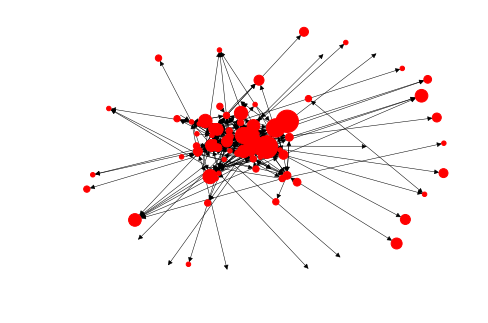

In [101]:
# nx.draw_kamada_kawai(G, node_size=[G.degree[x]**2.3 for x in G.nodes], arrowstyle='->',width=.5,  with_labels=False)
# plt.savefig("simu_userGraph.pdf")
nx.draw(G, node_size=[20*G.out_degree(k) for k in range(n)], width=.5)
# plt.savefig(out_path + "graph_random.pdf")

## 4. Compare real graph, oursin, cascade and Newman

Get oursin and cascade graph.

In [56]:
G_oursin = util.nxgraph_from_trace(trace_path, False, Author)
G_cascade = util.nxgraph_from_trace(trace_path, True, Author)

Wedge metric function.

In [57]:
def wedge_metric(graph):

    numerator = 0
    denominator = 0

    for i in graph.nodes:
        leaders = set(graph.predecessors(i))
        followers = set(graph.successors(i))
        friends = leaders.intersection(followers)
        if len(leaders) + len(followers) < 2:
            continue
        if leaders==followers and len(leaders)==1:
            continue
        L = len(leaders)
        F = len(followers)
        LintF = len(friends)
        numerator += L*F - LintF
        denominator += (L+F)**2 - L - F - 2*LintF

    if denominator != 0:
        result = 2 * numerator / denominator
    else:
        result = 0
        
    return result

Compare nb edges, proportion of common edges, wedge metric.

In [58]:
n_samples = 1000
sample_in_real = list()
real_in_sample = list()
sample_in_oursin = list()
oursin_in_sample = list()
sample_in_cascade = list()
cascade_in_sample = list()

# edges lists
oursin_edges = set(G_oursin.edges)
cascade_edges = set(G_cascade.edges)
real_edges = set(G.edges)
mean_sample_edges = 0
mean_wedge_metric_newman = 0

for k in range(n_samples):
    
    # sample graph
    G_sample = nx.DiGraph()
    G_sample.add_nodes_from(users)
    for (i,j) in node_pairs:
        if i in Q:
            if j in Q[i] and random.random() < Q[i][j]:
                G_sample.add_edge(j,i)
    sample_edges = set(G_sample.edges)
            
    # mean nb edges
    mean_sample_edges += len(sample_edges)
    
    # compare edges in sample with real graph
    nb_common_edges = len(sample_edges.intersection(real_edges))
    sample_in_real = nb_common_edges / len(sample_edges)
    real_in_sample = nb_common_edges / len(real_edges)
    
    # compare edges in sample with oursin graph
    nb_common_edges = len(sample_edges.intersection(oursin_edges))
    sample_in_oursin = nb_common_edges / len(sample_edges)
    oursin_in_sample = nb_common_edges / len(oursin_edges)
    
    # compare edges in sample with cascade graph
    nb_common_edges = len(sample_edges.intersection(cascade_edges))
    sample_in_cascade = nb_common_edges / len(sample_edges)
    cascade_in_sample = nb_common_edges / len(cascade_edges)
    
    # update mean wedge
    mean_wedge_metric_newman += wedge_metric(G_sample)
    
# update mean sample edges and mean wedge
mean_sample_edges /= n_samples
mean_wedge_metric_newman /= n_samples

# compare oursin and cascade with real
oursin_in_real = len(oursin_edges.intersection(real_edges)) / len(oursin_edges)
real_in_oursin = len(oursin_edges.intersection(real_edges)) / len(real_edges)
cascade_in_real = len(cascade_edges.intersection(real_edges)) / len(cascade_edges)
real_in_cascade = len(cascade_edges.intersection(real_edges)) / len(real_edges)
oursin_in_cascade = len(oursin_edges.intersection(cascade_edges)) / len(oursin_edges)
cascade_in_oursin = len(oursin_edges.intersection(cascade_edges)) / len(cascade_edges)

# print results
print("Mean nb edges in Newman graph : ", mean_sample_edges)
print("Nb edges in oursin graph : ", G_oursin.number_of_edges())
print("Nb edges in cascade graph : ", G_cascade.number_of_edges())
print("Real nb edges : ", G.number_of_edges())
print()
print("Mean prop of sample edges that are in real graph : ", np.mean(sample_in_real))
print("Mean prop of real edges that are in sample graph : ", np.mean(real_in_sample))
print()
print("Mean prop of sample edges that are in oursin graph : ", np.mean(sample_in_oursin))
print("Mean prop of oursin edges that are in sample graph : ", np.mean(oursin_in_sample))
print()
print("Mean prop of sample edges that are in cascade graph : ", np.mean(sample_in_cascade))
print("Mean prop of cascade edges that are in sample graph : ", np.mean(cascade_in_sample))
print()
print("Prop of oursin edges that are in real graph : ", oursin_in_real)
print("Prop of real edges that are in oursin graph : ", real_in_oursin)
print()
print("Prop of cascade edges that are in real graph : ", cascade_in_real)
print("Prop of real edges that are in cascade graph : ", real_in_cascade)
print()
print("Prop of oursin edges that are in cascade graph : ", oursin_in_cascade)
print("Prop of cascade edges that are in oursin graph : ", cascade_in_oursin)
print()
print("Wedge metric for real graph : ", wedge_metric(G))
print("Wedge metric for oursin graph : ", wedge_metric(G_oursin))
print("Wedge metric for cascade graph : ", wedge_metric(G_cascade))
print("Wedge metric for newman graph : ", mean_wedge_metric_newman)

Mean nb edges in Newman graph :  29.752
Nb edges in oursin graph :  333
Nb edges in cascade graph :  485
Real nb edges :  288

Mean prop of sample edges that are in real graph :  0.7333333333333333
Mean prop of real edges that are in sample graph :  0.0763888888888889

Mean prop of sample edges that are in oursin graph :  1.0
Mean prop of oursin edges that are in sample graph :  0.09009009009009009

Mean prop of sample edges that are in cascade graph :  0.8
Mean prop of cascade edges that are in sample graph :  0.049484536082474224

Prop of oursin edges that are in real graph :  0.3963963963963964
Prop of real edges that are in oursin graph :  0.4583333333333333

Prop of cascade edges that are in real graph :  0.30721649484536084
Prop of real edges that are in cascade graph :  0.5173611111111112

Prop of oursin edges that are in cascade graph :  0.3783783783783784
Prop of cascade edges that are in oursin graph :  0.2597938144329897

Wedge metric for real graph :  0.4074662430500397
Wed